# FIGURE 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from msresist.figures.figure1 import plotClustergram, plotVarReplicates, plotReplicatesEndpoint, plotAveragedEndpoint, plotReplicatesFoldChangeEndpoint, plotVarReplicates
import warnings
warnings.simplefilter("ignore")

## 1. Phosphorylation Measurements

Hierarchical Clustering of pre-processed data:

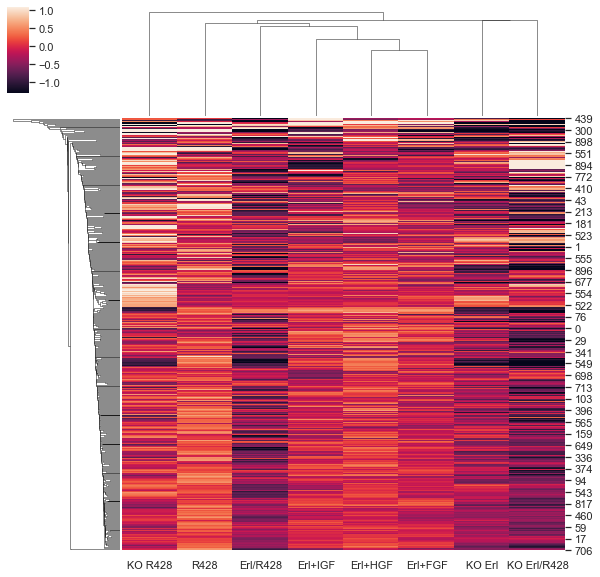

In [2]:
plotClustergram()

Variability of overlapping peptides across MS replicates. Pearson's correlation coefficient was computed for peptides overlapping across 2 MS replicates. For those overlapping 3 or more times, the Std was calculated.

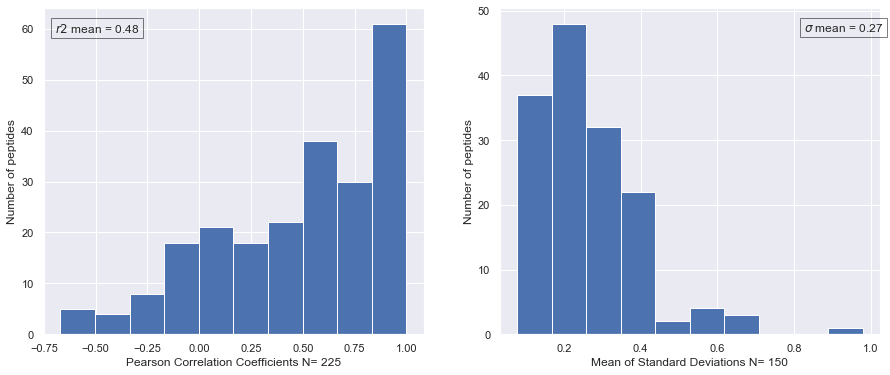

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
plotVarReplicates(ax)

## 2. Cell Viability Measurements:

Average between two replicates. Fold-change 72h vs 0h.

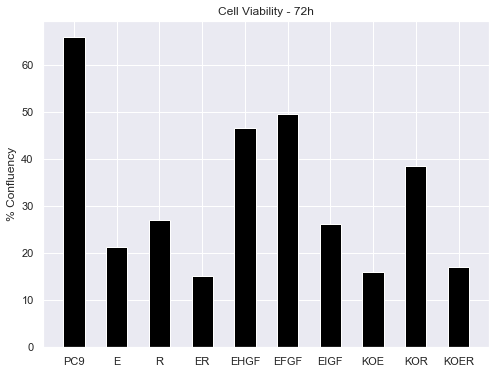

In [4]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

fig, ax = plt.subplots(1, 1, figsize=(8,6))
plotAveragedEndpoint(ax, Y_cv1, Y_cv2)

Raw Measurements of both replicates. Initial seeding was clearly off in Exp4.

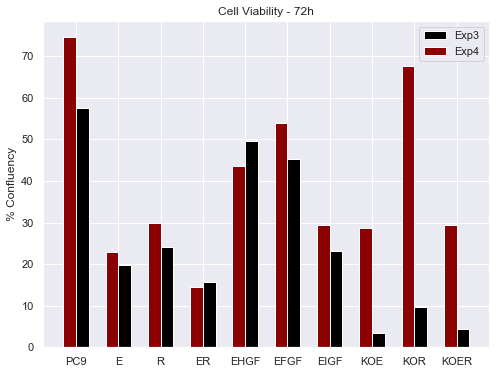

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
plotReplicatesEndpoint(ax, Y_cv1, Y_cv2)

However, by fold-changing to t=0h, both replicates are notably reproducible:

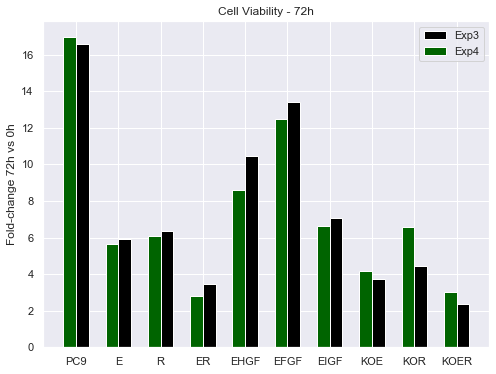

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
plotReplicatesFoldChangeEndpoint(ax, Y_cv1, Y_cv2)